In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import spacy
import joblib
import warnings
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from nltk.corpus import stopwords
from IPython.display import Image, display

In [2]:
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to C:\Users\KHUSHI
[nltk_data]     GUPTA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\KHUSHI
[nltk_data]     GUPTA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Display Theme Image
display(Image(url="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*Zqkg6_xWIRuA6P-3kbp6yA.png", width=600))

In [4]:
# Load Dataset
df = pd.read_csv("customer_support_tickets.csv")
display(df.head())

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [5]:
# Basic Info
df.info()
display(df.describe(include='object'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

,Customer Name,Customer Email,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution
count,8469,8469,8469,8469,8469,8469,8469,8469,8469,2769,8469,8469,5650,2769
unique,8028,8320,3,42,730,5,16,8077,3,2769,4,4,5470,2728
top,Michael Garcia,asmith@example.com,Male,Canon EOS,2020-10-21,Refund request,Refund request,I'm having an issue with the {product_purchase...,Pending Customer Response,We seat culture plan.,Medium,Email,2023-06-01 20:45:39,2023-06-01 17:14:42
freq,5,4,2896,240,24,1752,576,25,2881,1,2192,2143,3,3


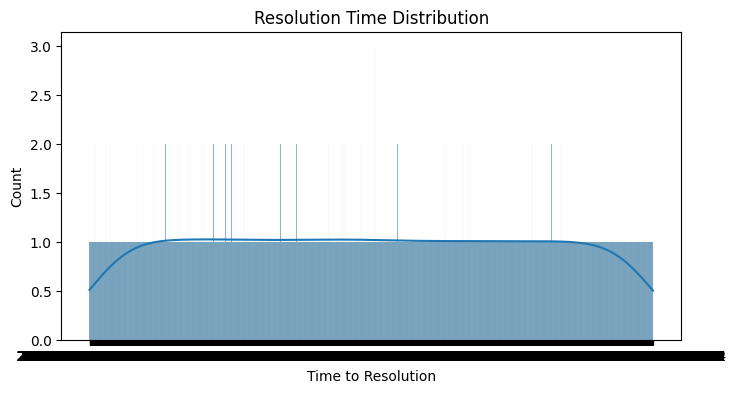

In [6]:
# Distribution of Resolution Time
plt.figure(figsize=(8,4))
sns.histplot(df['Time to Resolution'], bins=30, kde=True)
plt.title("Resolution Time Distribution")
plt.show()

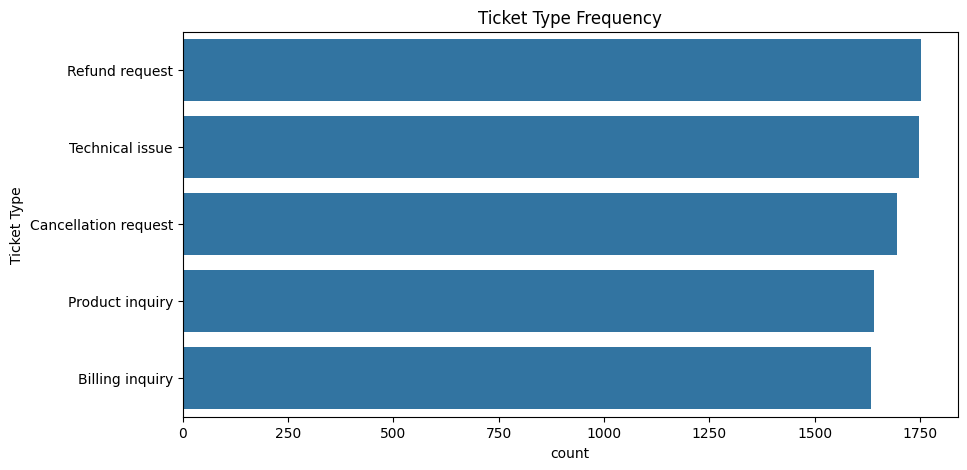

In [7]:
# Ticket Type Frequency
plt.figure(figsize=(10,5))
sns.countplot(y=df['Ticket Type'], order=df['Ticket Type'].value_counts().index)
plt.title("Ticket Type Frequency")
plt.show()

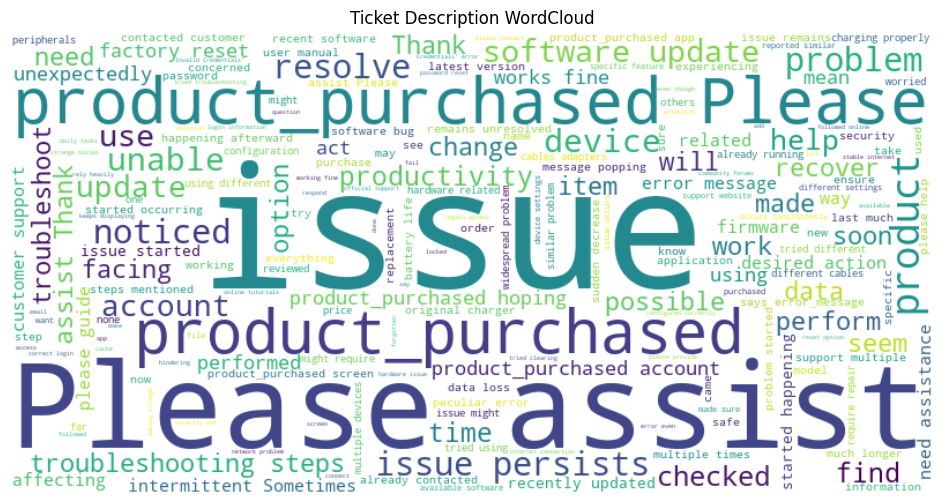

In [8]:
# Word Cloud of Descriptions
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['Ticket Description'].astype(str)))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Ticket Description WordCloud")
plt.show()

In [9]:
# Clean Text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in set(stopwords.words('english'))]
    return ' '.join(tokens)

In [10]:
# Apply Cleaning
df.dropna(subset=['Ticket Description'], inplace=True)
df['clean_text'] = df['Ticket Description'].astype(str).apply(clean_text)

In [11]:
# Named Entity Recognition
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

sample_entities = extract_entities(df['Ticket Description'].iloc[0])
print("Sample NER result:", sample_entities)


Sample NER result: [('71701', 'CARDINAL')]



📊 Classification Report:
                       precision    recall  f1-score   support

     Billing inquiry       0.17      0.11      0.13       357
Cancellation request       0.18      0.19      0.18       327
     Product inquiry       0.19      0.19      0.19       316
      Refund request       0.20      0.23      0.22       345
     Technical issue       0.21      0.25      0.23       349

            accuracy                           0.19      1694
           macro avg       0.19      0.19      0.19      1694
        weighted avg       0.19      0.19      0.19      1694



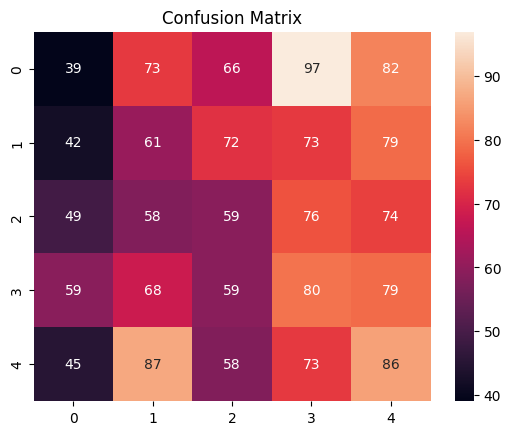

In [12]:
# Vectorization + Classification
X = df['clean_text']
y_class = df['Ticket Type']
y_reg = df['Time to Resolution']

vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vect, y_class, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


📈 Mean Absolute Error: 0.3147740365356993


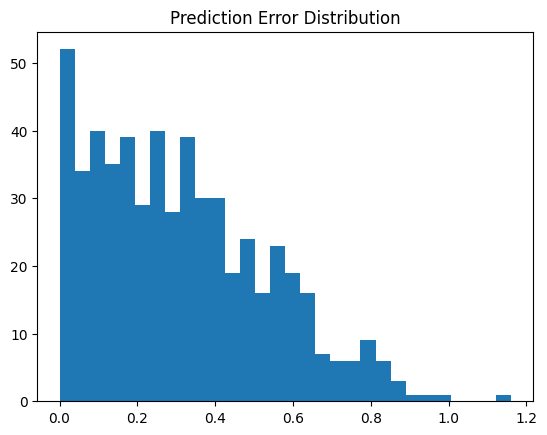

In [13]:
# Ensure 'Time to Resolution' is datetime (if it's actually a timestamp)
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'], errors='coerce')

# Drop rows where conversion failed or where it's NaT
df = df.dropna(subset=['Time to Resolution'])

# Optional: convert to days (or hours, depending on use case)
# If it's duration: df['Time to Resolution'] = df['Time to Resolution'].dt.total_seconds() / 86400
# If it's a fixed deadline/resolution time, subtract 'Created At' if available
df['Resolution_Days'] = (df['Time to Resolution'] - df['Time to Resolution'].min()).dt.total_seconds() / 86400

# Now use this column for regression
regression_df = df[['clean_text', 'Resolution_Days']].dropna()
X_reg = regression_df['clean_text']
y_reg = regression_df['Resolution_Days']

X_vect_reg = vectorizer.transform(X_reg)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_vect_reg, y_reg, test_size=0.2, random_state=42)

reg = MLPRegressor(max_iter=300)
reg.fit(X_train_r, y_train_r)
y_pred_r = reg.predict(X_test_r)

print("\n📈 Mean Absolute Error:", mean_absolute_error(y_test_r, y_pred_r))
plt.hist(abs(y_test_r - y_pred_r), bins=30)
plt.title("Prediction Error Distribution")
plt.show()


In [14]:
# Live Prediction Cell (Optional)
def predict_ticket(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred_class = clf.predict(vec)[0]
    pred_time = reg.predict(vec)[0]
    return pred_class, round(pred_time, 2)

example = "My payment didn't go through and app keeps crashing"
pred_class, pred_time = predict_ticket(example)
print(f"\nLive Prediction:\nTicket: '{example}'\n→ Category: {pred_class}, ETA: {pred_time} days")


Live Prediction:
Ticket: 'My payment didn't go through and app keeps crashing'
→ Category: Refund request, ETA: 0.52 days


In [15]:
import os
os.makedirs("models", exist_ok=True)

In [16]:
# Save Models and Vectorizer
joblib.dump(clf, "models/classifier.pkl")
joblib.dump(reg, "models/regressor.pkl")
joblib.dump(vectorizer, "models/vectorizer.pkl")

print("Models and vectorizer saved successfully.")

Models and vectorizer saved successfully.


In [17]:
import os
os.makedirs("models", exist_ok=True)

joblib.dump(clf, "models/classifier.pkl")
joblib.dump(reg, "models/regressor.pkl")
joblib.dump(vectorizer, "models/vectorizer.pkl")

print("✅ Models saved to /models/")


✅ Models saved to /models/
